In [1]:
from __future__ import print_function

import math
from functools import partial

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.python.data import Dataset

tf.get_logger().setLevel('ERROR')
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4634,-118.1,34.1,45.0,1095.0,237.0,672.0,234.0,3.4,209.2
9113,-119.0,35.4,38.0,1702.0,380.0,1191.0,366.0,1.9,57.8
2693,-117.7,33.6,19.0,2962.0,405.0,1295.0,440.0,6.1,248.0
9173,-119.0,35.3,12.0,2721.0,549.0,1294.0,523.0,2.6,100.2
13474,-122.0,37.2,20.0,2345.0,322.0,890.0,276.0,10.0,500.0
...,...,...,...,...,...,...,...,...,...
5246,-118.1,34.1,24.0,10239.0,2823.0,4210.0,2565.0,3.7,225.0
6896,-118.3,33.8,19.0,2356.0,440.0,1291.0,418.0,4.2,416.1
1205,-117.1,32.7,52.0,2676.0,557.0,1181.0,537.0,3.6,213.1
14269,-122.1,37.7,20.0,4296.0,817.0,1732.0,800.0,4.8,188.3


In [2]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [5]:
def train_model(learning_rate, steps, batch_size, input_feature):
    periods = 10
    steps_per_period = steps / periods

    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label].astype('float32')
    
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    my_optimizer = partial(optimizers.SGD, learning_rate=learning_rate, clipnorm=5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=my_optimizer)
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1,2,1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    print("Training model...")
    print("RMSE (on training data):")
    
    root_mean_squared_errors = []
    predictions = None
    for period in range (0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        print(" period %02d : %f" % (period, root_mean_squared_error))
        
        root_mean_squared_errors.append(root_mean_squared_error)
        
        y_extents = np.array([0, sample[my_label].max()])
        print("y_extents : ", y_extents)
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        print("weight : ", weight)
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        print("bias : ", bias)
        
        x_extents = (y_extents - bias) / weight
        print("x_extents : ", x_extents)
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        print("x_extents : ", x_extents)
        y_extents = weight * x_extents + bias
        print("y_extents : ", y_extents)
        
        plt.plot(x_extents, y_extents, color=colors[period])
    
    print("Model training finished")
    
    plt.subplot(1,2,2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error vs. Periods')
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMS (on training data): %f" % root_mean_squared_error)
    
    return calibration_data

Training model...
RMSE (on training data):
 period 00 : 204.637942
y_extents :  [  0.    500.001]
weight :  [12.5]
bias :  [12.5]
x_extents :  [-1.      39.00008]
x_extents :  [0.31194296 7.05471125]
y_extents :  [ 16.39928699 100.68389058]
 period 01 : 174.734989
y_extents :  [  0.    500.001]
weight :  [25.]
bias :  [25.]
x_extents :  [-1.      19.00004]
x_extents :  [0.31194296 7.05471125]
y_extents :  [ 32.79857398 201.36778116]
 period 02 : 149.639528
y_extents :  [  0.    500.001]
weight :  [37.5]
bias :  [37.5]
x_extents :  [-1.      12.33336]
x_extents :  [0.31194296 7.05471125]
y_extents :  [ 49.19786096 302.05167173]
 period 03 : 134.276592
y_extents :  [  0.    500.001]
weight :  [48.]
bias :  [48.]
x_extents :  [-1.         9.4166875]
x_extents :  [0.31194296 7.05471125]
y_extents :  [ 62.97326203 386.62613982]
 period 04 : 126.822464
y_extents :  [  0.    500.001]
weight :  [56.833336]
bias :  [57.202026]
x_extents :  [-1.00648722  7.79118394]
x_extents :  [0.31194296 7.05

,predictions,targets
count,17000.0,17000.0
mean,206.2,207.3
std,81.0,116.0
min,70.2,15.0
25%,174.4,119.4
50%,203.5,180.4
75%,228.2,265.0
max,3896.4,500.0


Final RMS (on training data): 126.998485


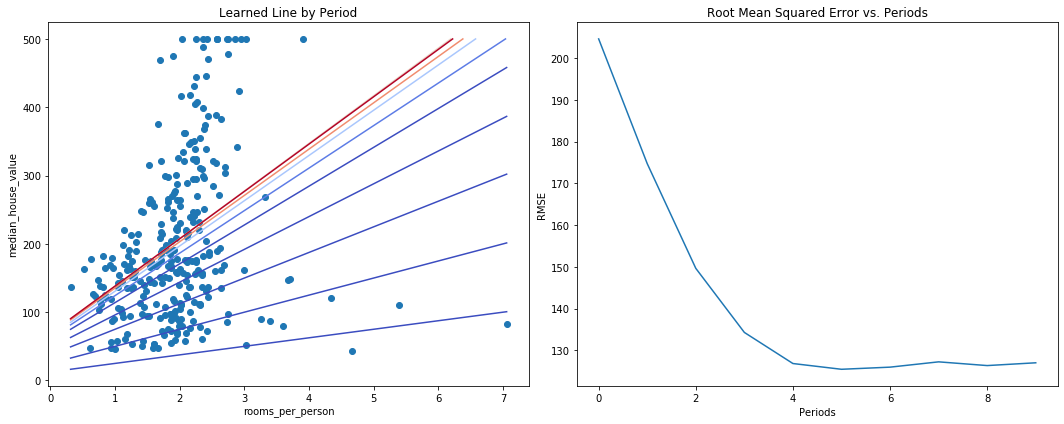

In [6]:
california_housing_dataframe["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])

calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

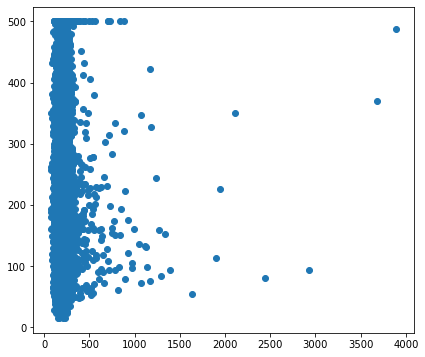

In [7]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])

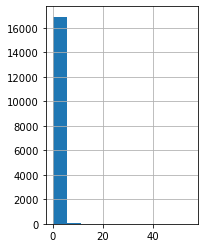

In [8]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

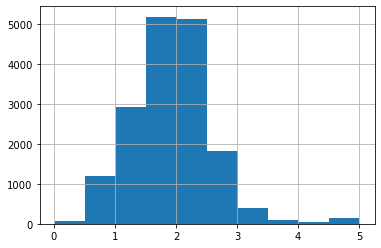

In [9]:
california_housing_dataframe["rooms_per_person"] = (
    california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))

_ = california_housing_dataframe["rooms_per_person"].hist()

Training model...
RMSE (on training data):
 period 00 : 204.653938
y_extents :  [  0.    500.001]
weight :  [12.5]
bias :  [12.5]
x_extents :  [-1.      39.00008]
x_extents :  [0.5315446  4.20208024]
y_extents :  [19.14430747 65.02600297]
 period 01 : 173.718337
y_extents :  [  0.    500.001]
weight :  [25.]
bias :  [25.]
x_extents :  [-1.      19.00004]
x_extents :  [0.5315446  4.20208024]
y_extents :  [ 38.28861494 130.05200594]
 period 02 : 145.978093
y_extents :  [  0.    500.001]
weight :  [37.5]
bias :  [37.5]
x_extents :  [-1.      12.33336]
x_extents :  [0.5315446  4.20208024]
y_extents :  [ 57.43292241 195.07800892]
 period 03 : 125.125254
y_extents :  [  0.    500.001]
weight :  [48.756504]
bias :  [49.5]
x_extents :  [-1.01524916  9.23981341]
x_extents :  [0.5315446  4.20208024]
y_extents :  [ 75.41625633 254.37874217]
 period 04 : 113.834288
y_extents :  [  0.    500.001]
weight :  [57.024387]
bias :  [59.29884]
x_extents :  [-1.03988561  7.7283103 ]
x_extents :  [0.5315446

,predictions,targets
count,17000.0,17000.0
mean,204.2,207.3
std,45.1,116.0
min,72.0,15.0
25%,175.4,119.4
50%,204.2,180.4
75%,228.7,265.0
max,414.6,500.0


Final RMS (on training data): 107.389192


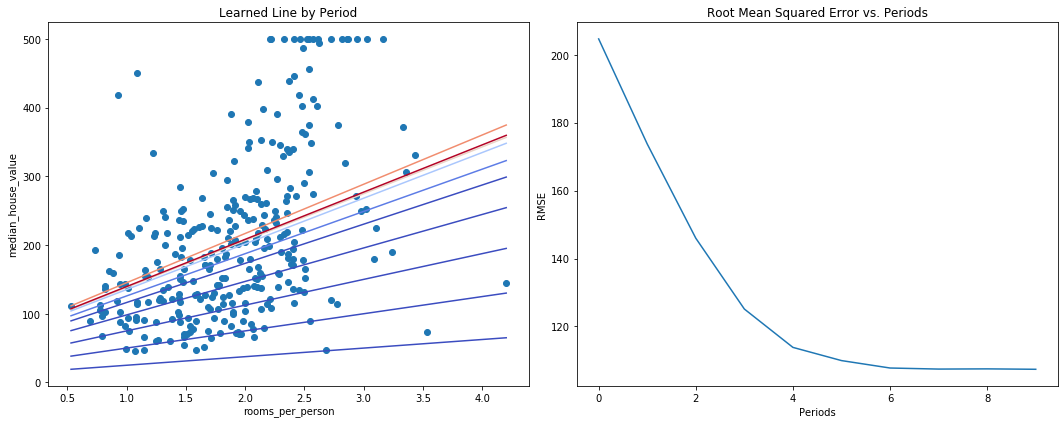

In [10]:
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person")

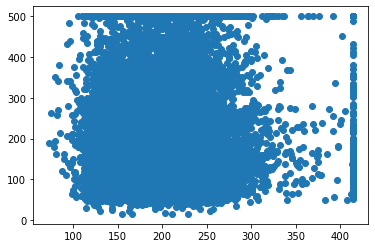

In [11]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])